In [19]:
import scipy
import serial
import time
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook
import scipy.signal as signal
from scipy.signal import find_peaks
from scipy import fftpack
from scipy.optimize import curve_fit
#from lmfit import Model
from numpy import exp, loadtxt, pi, sqrt

In [101]:
A1 = "20210624-143847-peixe1.csv"
A2 = "20210624-145602-peixe2.csv"
A3 = "20210624-151249-peixe3.csv"
A4 = "20210624-153033-peixe4.csv"
A5 = "20210624-155357-peixe5.csv"
data=pd.read_csv(A4)
data.columns = ['Tempo','Amplitude', 'Temperatura']

print(data)
begin= int(564/0.05)- int(10.10/0.05) 
finish = int(630/0.05)- int(10.10/0.05)

        Tempo  Amplitude  Temperatura
0       10.15        574        22.49
1       10.20       2395        21.89
2       10.25        448        22.39
3       10.30       3963        22.29
4       10.35          0        22.59
...       ...        ...          ...
16696  844.82       1597        22.49
16697  844.87       1573        22.39
16698  844.92       1568        22.49
16699  844.97       1548        22.59
16700  845.02       1561        22.39

[16701 rows x 3 columns]


<IPython.core.display.Javascript object>


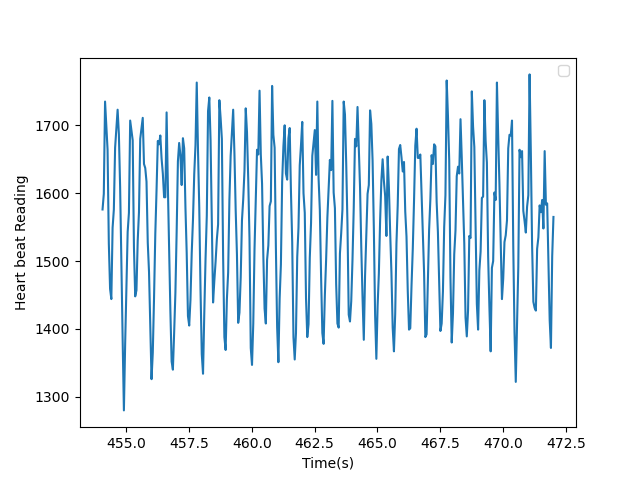

No handles with labels found to put in legend.


In [28]:
plt.plot(data['Tempo'][begin:finish],data['Amplitude'][begin:finish])
plt.legend(loc='best')
plt.xlabel('Time(s)')
plt.ylabel('Heart beat Reading')
plt.show()

## Filtering

<IPython.core.display.Javascript object>


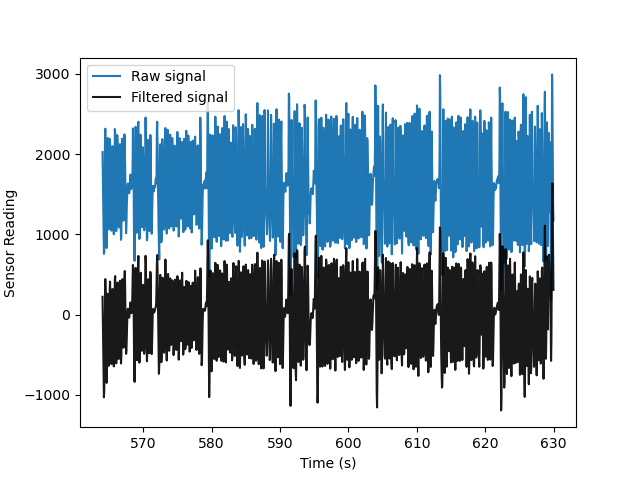

In [102]:
#Design the Butterworth filter
N  = 2                 # Filter order
Wn = [0.01, 0.4]       # Cutoff frequency
B, A = signal.butter(N, Wn,'bandpass', output='ba')
smooth_data = signal.filtfilt(B,A, data['Amplitude'][begin:finish])

plt.plot(data['Tempo'][begin:finish],data['Amplitude'][begin:finish], '-', color='C0', label='Raw signal', alpha = 1)
plt.plot(data['Tempo'][begin:finish],smooth_data,'k-', label='Filtered signal', alpha = 0.9)
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Sensor Reading')
plt.show()

In [74]:
plt.savefig('peixe5-290-326-filt.png')

## FFT

In [23]:
D = data['Amplitude'][begin:finish].to_numpy()
Y_raw =abs(np.fft.fft(D))
Y_smooth = abs(np.fft.fft(smooth_data))
Ta = 0.05
Fa=1/Ta
N=data['Tempo'][begin:finish].size
x_fft=np.linspace(0.0,1.0/(2.0*Ta),N//2) #metade da fft
f_raw = 2.0/N * abs(Y_raw[:N//2]) #normalização e só temos metade da fft, porque a fft acaba por ser um espelho 
f_smooth = 2.0/N * abs(Y_smooth[:N//2])
n=len(x_fft)

<IPython.core.display.Javascript object>


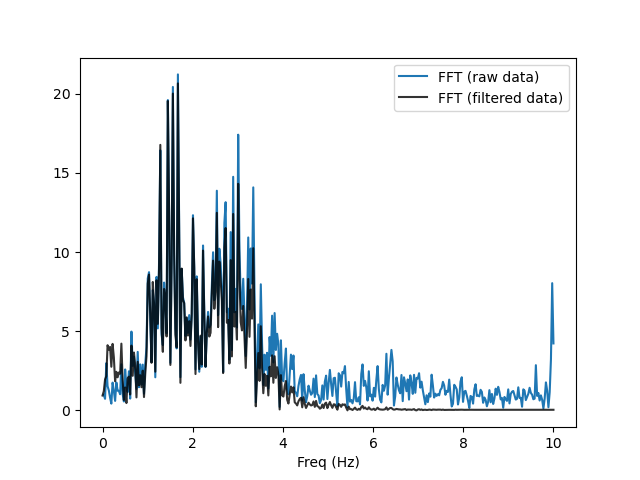

In [113]:
plt.plot(x_fft[1:],f_raw[1:], color='C0', label = 'FFT (raw data)', alpha = 1)
plt.plot(x_fft[:],f_smooth[:],'k', label = 'FFT (filtered data)', alpha = 0.8)
plt.legend(loc='best')
plt.xlabel('Freq (Hz)')
plt.show()

In [114]:
plt.savefig('peixe5-290-326-FFT_rawandsmooth.png')

## Gaussian Fit

In [5]:
#Gaussian function
def gaussian(x, a, mean, sigma):
    return a*np.exp(-(x-mean)**2/(2*sigma**2))

def gaussian_sum2(x, a, mean, sigma, a1, mean1, sigma1):
    return (a*np.exp(-(x-mean)**2/(2*sigma**2))) + (a1*np.exp(-(x-mean1)**2/(2*sigma1**2)))

def gaussian_sum3(x, a, mean, sigma, a1, mean1, sigma1, a2, mean2, sigma2):
    return (a*np.exp(-(x-mean)**2/(2*sigma**2))) + (a1*np.exp(-(x-mean1)**2/(2*sigma1**2))) + (a2*np.exp(-(x-mean2)**2/(2*sigma2**2)))

def gaussian_sum4(x, a, mean, sigma, a1, mean1, sigma1, a2, mean2, sigma2, a3, mean3, sigma3):
    return (a*np.exp(-(x-mean)**2/(2*sigma**2))) + (a1*np.exp(-(x-mean1)**2/(2*sigma1**2))) + (a2*np.exp(-(x-mean2)**2/(2*sigma2**2))) + (a3*np.exp(-(x-mean3)**2/(2*sigma3**2)))

#mean=sum(x_fft*f)/n
#sigma=sum(f*(x_fft-mean)**2)/n

In [22]:
# best_vals, cov_vals = curve_fit(f=gaussian_sum2, xdata=x_fft, ydata = f_smooth, p0=[10, 1.5,0.5, 5,2,0.5]) #best_vals = melhores valores para a, mean e sigma
best_vals, cov_vals = curve_fit(f=gaussian, xdata=x_fft, ydata = f_smooth, p0=[40,2,0.5])
print(best_vals)

[30.84044838  1.81053711  0.5467605 ]


Gaussiana 1: 1.810537106282583


<IPython.core.display.Javascript object>


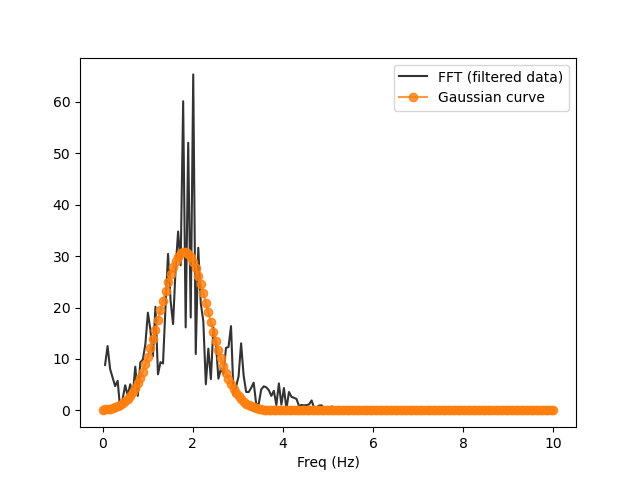

In [25]:
y_fft1 = gaussian(x_fft,best_vals[0],best_vals[1],best_vals[2])
print("Gaussiana 1: {}".format(best_vals[1]))
# y_fft2 = gaussian(x_fft,best_vals[3],best_vals[4],best_vals[5])
# print("Gaussiana 2: {}".format(best_vals[4]))
# y_fft3 = gaussian(x_fft,best_vals[6],best_vals[7],best_vals[8])
# print("Gaussiana 3: {}".format(best_vals[7]))

plt.plot(x_fft[1:],f_smooth[1:],'k',label='FFT (filtered data)', alpha = 0.8)
plt.plot(x_fft,gaussian(x_fft, *best_vals),'o-',color = 'C1',label='Gaussian curve', alpha = 0.8)
plt.legend(loc='best')
plt.xlabel('Freq (Hz)')
plt.show()

In [26]:
plt.savefig('peixe2-454-472-sum_gauss.png')

<IPython.core.display.Javascript object>


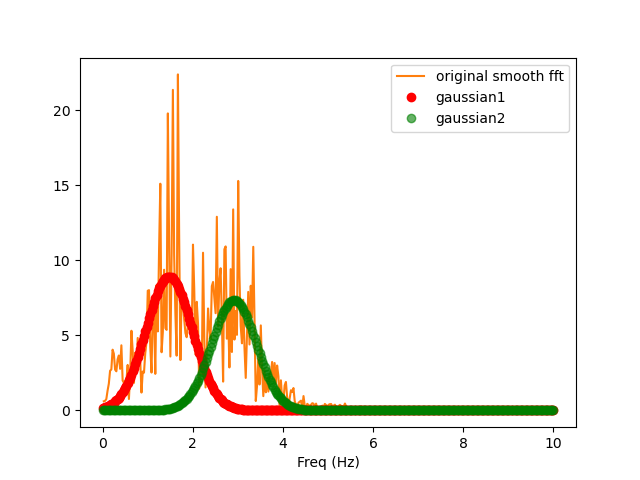

In [426]:
plt.plot(x_fft[1:],f_smooth[1:],'tab:orange',label='original smooth fft')
plt.plot(x_fft, y_fft1, 'ro', label = 'gaussian1')
plt.plot(x_fft, y_fft2, 'go', label = 'gaussian2', alpha = 0.6)
# plt.plot(x_fft, y_fft3, 'bo', label = 'gaussian3',alpha = 0.6)
plt.legend(loc='best')
plt.xlabel('Freq (Hz)')
plt.show()

In [427]:
plt.savefig('peixe5-290-326-gaussians.png')

In [162]:
summ = gaussian_sum2(x_fft, best_vals[3], best_vals[4], best_vals[5], best_vals[6], best_vals[7],  best_vals[8])
plt.plot(x_fft[1:],f_smooth[1:],'b+:',label='original smooth fft')
plt.plot(x_fft, summ , 'ro', label = 'gaussian_sum')
plt.legend(loc='best')
plt.xlabel('Freq (Hz)')
plt.show()

IndexError: index 6 is out of bounds for axis 0 with size 6

In [88]:
plt.savefig('peixe2-342-380-gaussians2.png')

### Pwelch

<IPython.core.display.Javascript object>


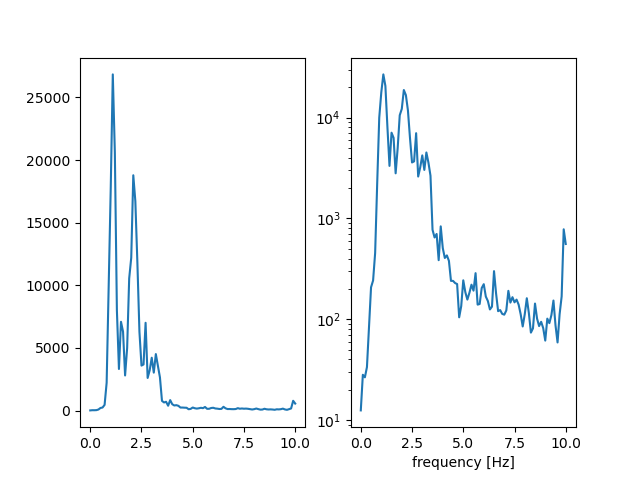

In [18]:
f1, Pxx_den = signal.welch(D, 20, nperseg=200, noverlap = 20)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(f1, Pxx_den)
ax2.semilogy(f1, Pxx_den)
plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
plt.show()

## Find_peaks

167


<IPython.core.display.Javascript object>


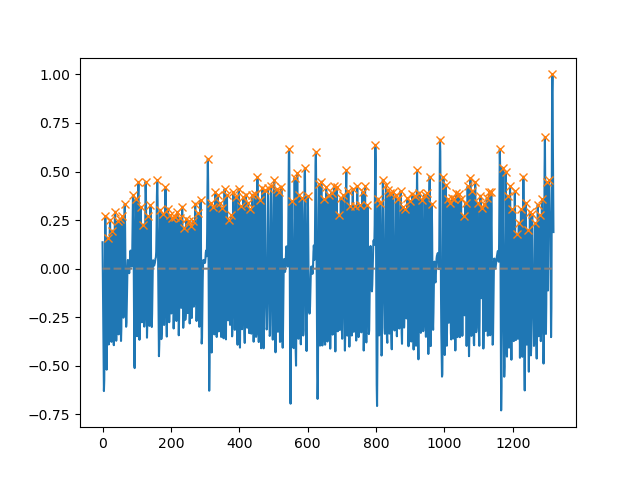

In [103]:
smooth_data = smooth_data/max(smooth_data)
peaks, _ = find_peaks(smooth_data, height = 0.15, distance =5, threshold = 0.00001) #retorna os indices dos picos 
print(len(peaks))
plt.plot(smooth_data)
plt.plot(peaks, smooth_data[peaks], "x")
plt.plot(np.zeros_like(smooth_data), "--", color="gray")
plt.show()

In [118]:
heart_beat = []

for n in range(len(peaks)-1):
    delta_t = data['Tempo'][peaks[n+1]]-data['Tempo'][peaks[n]]
    if delta_t < 7:
        f_min = 60/delta_t
        heart_beat.append(f_min)
        
    else:
        print("error")
        
#hb = np.around(heart_beat, 2)
#print(len(hb))
print(heart_beat)
print(round(np.mean(heart_beat),1))


[171.42857142857162, 171.42857142857162, 171.42857142857162, 149.99999999999986, 171.42857142857162, 171.42857142857162, 171.42857142857073, 171.42857142857162, 50.00000000000003, 149.99999999999986, 149.99999999999986, 171.42857142857162, 171.42857142857073, 171.42857142857247, 149.9999999999992, 200.0000000000019, 60.0, 133.3333333333325, 171.42857142857247, 149.9999999999992, 150.00000000000054, 199.99999999999952, 199.99999999999952, 150.00000000000054, 171.42857142857073, 150.00000000000054, 199.99999999999952, 199.99999999999952, 200.0000000000019, 171.42857142857073, 199.99999999999952, 199.99999999999952, 171.42857142857247, 149.9999999999992, 150.00000000000054, 57.1428571428571, 150.00000000000054, 171.42857142857073, 171.42857142857247, 171.42857142857073, 171.42857142857073, 200.0000000000019, 171.42857142857073, 171.42857142857073, 200.0000000000019, 199.99999999999952, 171.42857142857073, 150.00000000000054, 171.42857142857073, 171.42857142857247, 171.42857142857073, 171.

In [13]:
#tempos dos picos
t = list(data['Tempo'][begin:finish])
td = []
for m in range(len(peaks)):
    u = peaks[m]
    td.append(t[u])
print(td)

[454.21, 454.66, 455.21, 455.61, 456.31, 457.26, 457.81, 458.31, 458.76, 459.26, 459.76, 460.31, 460.86, 461.31, 461.96, 462.56, 463.21, 463.71, 464.21, 464.76, 465.21, 465.91, 466.56, 467.26, 467.76, 468.31, 468.81, 469.26, 469.76, 470.31, 470.71, 471.06]


### Remove heart rate values outside 2 desvio padrão

In [119]:
up = 166 + 20
down = 166 - 20
length = len(heart_beat)-1
for element in heart_beat:
    if element > up:
        heart_beat.remove(element)
    if element < down:
        heart_beat.remove(element)
print(len(heart_beat))
print(heart_beat)
# print(down)
print(round(np.mean(heart_beat),1))

119
[171.42857142857162, 171.42857142857162, 171.42857142857162, 149.99999999999986, 171.42857142857162, 171.42857142857162, 171.42857142857073, 171.42857142857162, 149.99999999999986, 149.99999999999986, 171.42857142857162, 171.42857142857073, 171.42857142857247, 149.9999999999992, 60.0, 171.42857142857247, 149.9999999999992, 150.00000000000054, 150.00000000000054, 171.42857142857073, 150.00000000000054, 171.42857142857073, 199.99999999999952, 199.99999999999952, 171.42857142857247, 149.9999999999992, 150.00000000000054, 150.00000000000054, 171.42857142857073, 171.42857142857247, 171.42857142857073, 171.42857142857073, 171.42857142857073, 171.42857142857073, 199.99999999999952, 171.42857142857073, 150.00000000000054, 171.42857142857073, 171.42857142857247, 171.42857142857073, 171.42857142857073, 171.42857142857247, 199.99999999999952, 149.99999999999787, 171.4285714285742, 149.99999999999787, 171.42857142857073, 171.42857142857073, 171.42857142857073, 171.4285714285742, 171.4285714285

# Calculo do erro dos sensores

169.10919540229867
15.559058936367771
[ 2  0 29  0  0 70  0  0  0 15]
[133.33333333 140.         146.66666667 153.33333333 160.
 166.66666667 173.33333333 180.         186.66666667 193.33333333
 200.        ]
None
Gaussiana 1: [ 70.70863    166.81573486   1.0506367 ]


<IPython.core.display.Javascript object>


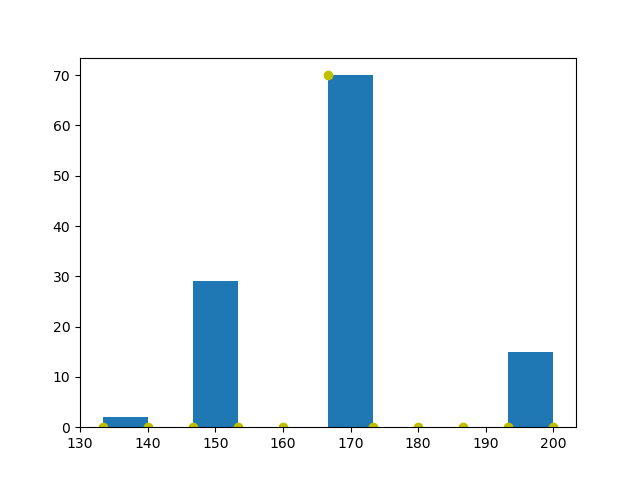

(array([ 2.,  0., 29.,  0.,  0., 70.,  0.,  0.,  0., 15.]),
 array([133.33333333, 140.        , 146.66666667, 153.33333333,
        160.        , 166.66666667, 173.33333333, 180.        ,
        186.66666667, 193.33333333, 200.        ]),
 <BarContainer object of 10 artists>)

In [117]:
from scipy.stats import norm
import statistics
mean = statistics.mean(heart_beat)
sd = statistics.stdev(heart_beat)
print(mean)
print(sd)
from scipy.optimize import curve_fit
def gaussian(x, a, mean, sigma):
    return a*np.exp(-(x-mean)**2/(2*sigma**2))

hist, bin_edges = np.histogram(heart_beat, bins = 10)
print(hist)
print(bin_edges)
best_vals, cov_vals = curve_fit(f=gaussian, xdata=bin_edges[:-1],ydata=hist, p0=[10, mean, sd])
h=list(hist).remove(0)
print(h)
print("Gaussiana 1: {}".format(best_vals))
plt.plot(bin_edges,gaussian(bin_edges, *best_vals),'yo',label='gaussian_sum')
# plt.plot( bin_edges[:-1], hist, 'o')
plt.hist(heart_beat)